In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

warnings.filterwarnings('ignore')

# Load dataset
data_test = pd.read_csv('/content/drive/MyDrive/Train AI/Train AI/test_data.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Train AI/Train AI/train_data.csv')

data_test1 = data_test.dropna()
data_train1 = data_train.dropna()

#print("Số lượng trước khi lọc các cột:", data_non_null.shape[0])
#print('\n')

# Xử lý dữ liệu
X_test = data_test1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_test = data_test1['aws']
X_train = data_train1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_train = data_train1['aws']

# Apply min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 1. Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
r2_scores = []

# Tạo thư mục lưu mô hình
checkpoint_dir = '/content/drive/MyDrive/Train AI/Train AI/save/test_tabnet'
os.makedirs(checkpoint_dir, exist_ok=True)

# 2. Định nghĩa các tham số cần tối ưu (ví dụ: n_d, n_a, n_steps, gamma)
param_grid = {
    'n_d': [16, 32, 64],  # Số chiều của quyết định
    'n_a': [16, 32, 64],  # Số chiều attention
    'n_steps': [3, 5, 7],  # Số bước quyết định
    'gamma': [1.0, 1.3, 1.5],  # Tham số gamma
}

# 3. Lặp qua các tham số và thực hiện cross-validation
best_params = None
best_score = float('inf')  # MSE thấp hơn là tốt hơn, nên khởi tạo bằng vô cùng

for n_d in param_grid['n_d']:
    for n_a in param_grid['n_a']:
      if n_a == n_d:
        for n_steps in param_grid['n_steps']:
            for gamma in param_grid['gamma']:
                print(f"Training with n_d={n_d}, n_a={n_a}, n_steps={n_steps}, gamma={gamma}")

                # Thiết lập mô hình với tham số hiện tại
                tabnet_model = TabNetRegressor(
                    n_d=n_d,
                    n_a=n_a,
                    n_steps=n_steps,
                    gamma=gamma,
                    cat_idxs=[],  # Thêm chỉ số của các đặc trưng phân loại nếu có
                    cat_dims=[],  # Số lượng danh mục của các đặc trưng phân loại
                    cat_emb_dim=1
                )

                fold_mae_scores = []
                fold_mse_scores = []
                fold_r2_scores = []

                # Cross-validation - train và validation
                for train_idx, val_idx in kf.split(X_train_scaled):
                    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
                    y_train_fold, y_val_fold = y_train.values[train_idx], y_train.values[val_idx]

                    # Huấn luyện mô hình với tập huấn luyện của fold
                    tabnet_model.fit(
                        X_train_fold, y_train_fold.reshape(-1, 1),
                        max_epochs=5,
                        eval_set=[(X_val_fold, y_val_fold.reshape(-1, 1))],
                        eval_metric=['rmse'],
                        patience=20
                    )

                    # Dự đoán trên tập validation
                    y_pred_val = tabnet_model.predict(X_val_fold)

                    # Lưu các chỉ số hiệu suất
                    fold_mae_scores.append(mean_absolute_error(y_val_fold, y_pred_val))
                    fold_mse_scores.append(mean_squared_error(y_val_fold, y_pred_val))
                    fold_r2_scores.append(r2_score(y_val_fold, y_pred_val))

                # Tính trung bình các chỉ số từ cross-validation
                mean_fold_mae = np.mean(fold_mae_scores)
                mean_fold_mse = np.mean(fold_mse_scores)
                mean_fold_r2 = np.mean(fold_r2_scores)

                print(f"Mean MAE: {mean_fold_mae}, Mean MSE: {mean_fold_mse}, Mean R²: {mean_fold_r2}")

                # Cập nhật tham số tốt nhất nếu cần
                if mean_fold_mse < best_score:
                    best_score = mean_fold_mse
                    best_params = {
                        'n_d': n_d,
                        'n_a': n_a,
                        'n_steps': n_steps,
                        'gamma': gamma
                    }

# 4. In ra tham số tốt nhất
print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_score}")

# 5. Đánh giá trên tập kiểm tra (test set)
tabnet_model = TabNetRegressor(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=1
)

# Huấn luyện lại trên toàn bộ tập huấn luyện với tham số tốt nhất
tabnet_model.fit(
    X_train_scaled, y_train.values.reshape(-1, 1),
    max_epochs=100,
    eval_metric=['rmse'],
    patience=20
)

# Dự đoán trên test set
y_pred_test = tabnet_model.predict(X_test_scaled)

# Tính MAE, MSE, và R² trên test set
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'MAE on test set: {mae_test}')
print(f'MSE on test set: {mse_test}')
print(f'R² on test set: {r2_test}')

# 5. Lưu kết quả vào file
results_path = os.path.join(checkpoint_dir, 'final_results_tuning.txt')
with open(results_path, 'w') as file:
    # file.write(f"Cross-validation Mean MAE: {mean_mae}\n")
    # file.write(f"Cross-validation Mean MSE: {mean_mse}\n")
    # file.write(f"Cross-validation Mean R²: {mean_r2}\n")
    file.write(f"Test Set MAE: {mae_test}\n")
    file.write(f"Test Set MSE: {mse_test}\n")
    file.write(f"Test Set R²: {r2_test}\n")

Training with n_d=16, n_a=16, n_steps=3, gamma=1.0
epoch 0  | loss: 4.09024 | val_0_rmse: 2.18836 |  0:00:07s
epoch 1  | loss: 3.50295 | val_0_rmse: 2.16953 |  0:00:15s
epoch 2  | loss: 3.36945 | val_0_rmse: 2.01361 |  0:00:22s
epoch 3  | loss: 3.31933 | val_0_rmse: 1.91274 |  0:00:32s
epoch 4  | loss: 3.46779 | val_0_rmse: 1.79501 |  0:00:40s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_rmse = 1.79501
epoch 0  | loss: 4.30483 | val_0_rmse: 2.32844 |  0:00:07s
epoch 1  | loss: 3.95265 | val_0_rmse: 2.19856 |  0:00:15s
epoch 2  | loss: 3.5224  | val_0_rmse: 2.02445 |  0:00:23s
epoch 3  | loss: 3.46082 | val_0_rmse: 1.91972 |  0:00:30s
epoch 4  | loss: 3.48522 | val_0_rmse: 1.8153  |  0:00:38s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_rmse = 1.8153
epoch 0  | loss: 3.99937 | val_0_rmse: 2.42544 |  0:00:08s
epoch 1  | loss: 3.56519 | val_0_rmse: 2.32542 |  0:00:14s
epoch 2  | loss: 3.55875 | val_0_rmse: 2.203

In [4]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Load dataset
data_test = pd.read_csv('/content/drive/MyDrive/Train AI/Train AI/test_data.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Train AI/Train AI/train_data.csv')

data_test1 = data_test.dropna()
data_train1 = data_train.dropna()

#print("Số lượng trước khi lọc các cột:", data_non_null.shape[0])
#print('\n')

# Xử lý dữ liệu
X_test = data_test1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_test = data_test1['aws']
X_train = data_train1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_train = data_train1['aws']

# Apply min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 1. Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
r2_scores = []

# Tạo thư mục lưu mô hình
checkpoint_dir = '/content/drive/MyDrive/Train AI/Train AI/save/test_tabnet'
os.makedirs(checkpoint_dir, exist_ok=True)

# 5. Đánh giá trên tập kiểm tra (test set)
tabnet_model = TabNetRegressor(
    n_d=16,
    n_a=16,
    n_steps=3,
    gamma=1,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=1
)

# Huấn luyện lại trên toàn bộ tập huấn luyện với tham số tốt nhất
tabnet_model.fit(
    X_train_scaled, y_train.values.reshape(-1, 1),
    max_epochs=50,
    eval_metric=['rmse'],
    patience=20
)

# Dự đoán trên test set
y_pred_test = tabnet_model.predict(X_test_scaled)

# Tính MAE, MSE, và R² trên test set
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'MAE on test set: {mae_test}')
print(f'MSE on test set: {mse_test}')
print(f'R² on test set: {r2_test}')

# 5. Lưu kết quả vào file
results_path = os.path.join(checkpoint_dir, 'final_results_tuning1.txt')
with open(results_path, 'w') as file:
    # file.write(f"Cross-validation Mean MAE: {mean_mae}\n")
    # file.write(f"Cross-validation Mean MSE: {mean_mse}\n")
    # file.write(f"Cross-validation Mean R²: {mean_r2}\n")
    file.write(f"Test Set MAE: {mae_test}\n")
    file.write(f"Test Set MSE: {mse_test}\n")
    file.write(f"Test Set R²: {r2_test}\n")

epoch 0  | loss: 4.14117 |  0:00:15s
epoch 1  | loss: 3.59965 |  0:00:29s
epoch 2  | loss: 3.50061 |  0:00:41s
epoch 3  | loss: 3.41975 |  0:00:53s
epoch 4  | loss: 3.301   |  0:01:05s
epoch 5  | loss: 3.36599 |  0:01:17s
epoch 6  | loss: 3.22982 |  0:01:30s
epoch 7  | loss: 3.2589  |  0:01:40s
epoch 8  | loss: 3.28538 |  0:01:52s
epoch 9  | loss: 3.31992 |  0:02:04s
epoch 10 | loss: 3.31228 |  0:02:16s
epoch 11 | loss: 3.2896  |  0:02:28s
epoch 12 | loss: 3.31264 |  0:02:39s
epoch 13 | loss: 3.41531 |  0:02:50s
epoch 14 | loss: 3.3417  |  0:03:02s
epoch 15 | loss: 3.34497 |  0:03:15s
epoch 16 | loss: 3.2905  |  0:03:27s
epoch 17 | loss: 3.24166 |  0:03:40s
epoch 18 | loss: 3.22957 |  0:03:51s
epoch 19 | loss: 3.23423 |  0:04:02s
epoch 20 | loss: 3.19384 |  0:04:14s
epoch 21 | loss: 3.22082 |  0:04:26s
epoch 22 | loss: 3.2147  |  0:04:38s
epoch 23 | loss: 3.17836 |  0:04:50s
epoch 24 | loss: 3.22242 |  0:05:01s
epoch 25 | loss: 3.19737 |  0:05:13s
epoch 26 | loss: 3.1826  |  0:05:25s
e

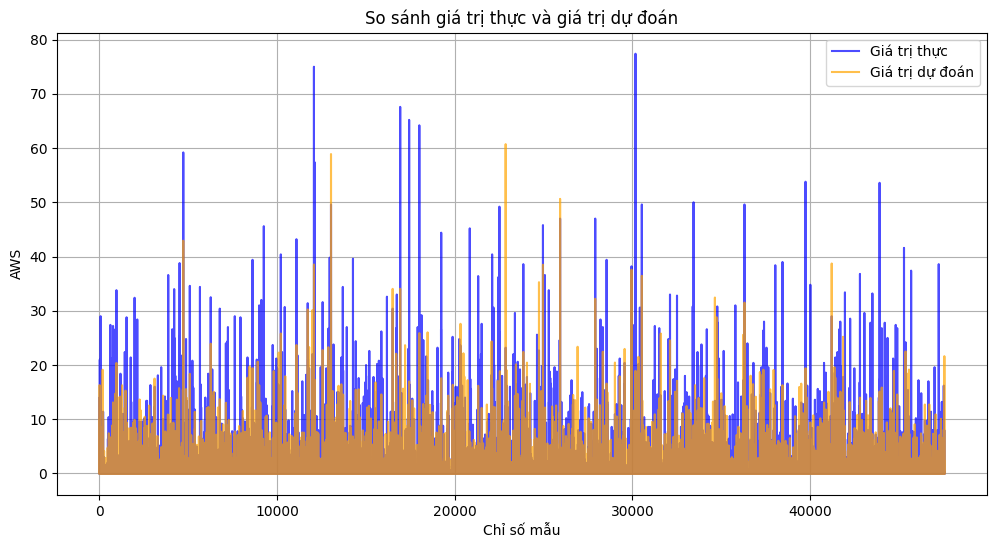

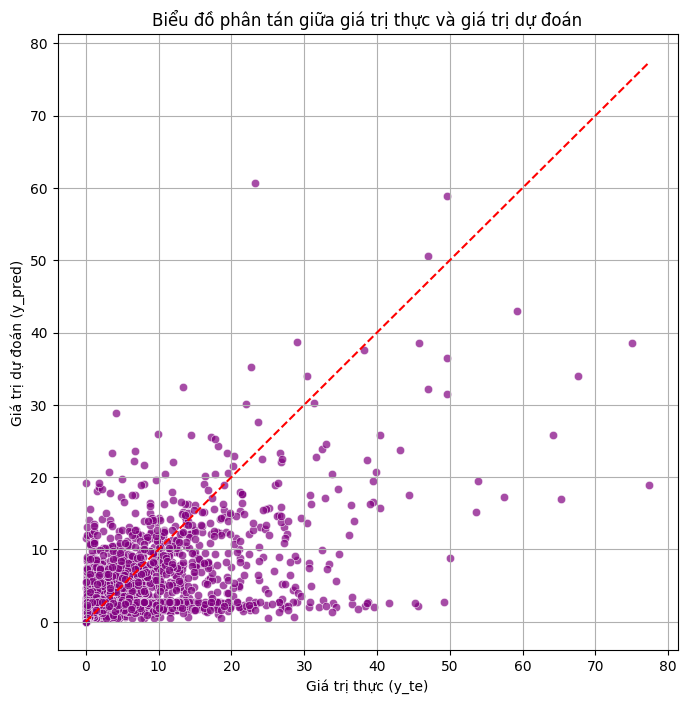

Biểu đồ đường đã được lưu tại: /content/drive/MyDrive/Train AI/Train AI/save/plots/line_plot.png
Biểu đồ phân tán đã được lưu tại: /content/drive/MyDrive/Train AI/Train AI/save/plots/scatter_plot.png


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thư mục lưu trữ trên Google Drive
output_dir = '/content/drive/MyDrive/Train AI/Train AI/save/plots'
os.makedirs(output_dir, exist_ok=True)

# Vẽ và lưu biểu đồ đường
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Giá trị thực', color='blue', alpha=0.7)
plt.plot(y_pred_test, label='Giá trị dự đoán', color='orange', alpha=0.7)
plt.title('So sánh giá trị thực và giá trị dự đoán')
plt.xlabel('Chỉ số mẫu')
plt.ylabel('AWS')
plt.legend()
plt.grid(True)
line_plot_path = os.path.join(output_dir, 'line_plot.png')
plt.savefig(line_plot_path, format='png')
plt.show()

# Vẽ và lưu biểu đồ phân tán
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test.values, y=y_pred_test.flatten(), alpha=0.7, color='purple')
plt.title('Biểu đồ phân tán giữa giá trị thực và giá trị dự đoán')
plt.xlabel('Giá trị thực (y_te)')
plt.ylabel('Giá trị dự đoán (y_pred)')
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)],
         color='red', linestyle='--', linewidth=1.5)  # Đường y=x để so sánh
plt.grid(True)
scatter_plot_path = os.path.join(output_dir, 'scatter_plot.png')
plt.savefig(scatter_plot_path, format='png')
plt.show()

print(f"Biểu đồ đường đã được lưu tại: {line_plot_path}")
print(f"Biểu đồ phân tán đã được lưu tại: {scatter_plot_path}")

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')


In [ ]:
# Load test data
data_test = pd.read_csv('/content/drive/MyDrive/Train AI/test_data.csv')
data_non_null = data_test.dropna()

# Initialize the TabNet model
tabnet_model = TabNetRegressor(cat_idxs=[], cat_dims=[], cat_emb_dim=1)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

X_test = data_test.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_test = data_test['aws']

# Apply min-max scaling
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Create directory to store model and parameters if it doesn't exist
checkpoint_dir = '/content/drive/MyDrive/Train AI/save/test_tabnet'
os.makedirs(checkpoint_dir, exist_ok=True)

# Predict on the test set (second half of the data)
y_test_pred = data_test.predict(X_test_scaled)

# Calculate RSE and R² for the test set
test_rse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r_squared = r2_score(y_test, y_test_pred)

# Print the results for the test set
print("Test Root Squared Error (RSE):", test_rse)
print("Test R² Score:", test_r_squared)

# Save the best model as a binary object in a .joblib file, then read the contents for writing to the .txt file
combined_path = os.path.join(checkpoint_dir, 'temp_model.joblib')
joblib.dump(tabnet_model, combined_path)

# Append test metrics to the file
with open(combined_path, 'a') as txt_file:
    txt_file.write("\nTest Metrics:\n")
    txt_file.write(f"Test Root Squared Error (RSE): {test_rse}\n")
    txt_file.write(f"Test R² Score: {test_r_squared}\n")


print("Model, parameters, and test metrics have been saved in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")


AttributeError: 'DataFrame' object has no attribute 'predict'

In [ ]:
# Load train data
data_train = pd.read_csv('/content/drive/MyDrive/Train AI/test_data.csv')
data_non_null = data_test.dropna()

# Feature and target separation
X = data_test.drop(columns=['timestamp', 'col', 'row', 'aws'])
y = data_test['aws']

X_scaled = scaler.fit_transform(X)

# Define the parameter grid for random search
#param_grid = {
#    'n_d': np.arange(8, 32, 4),
#    'n_a': np.arange(8, 32, 4),
#    'n_steps': np.arange(3, 10, 1),
#    'gamma': np.linspace(1.0, 2.0, 5),
#    'lambda_sparse': np.logspace(-5, -1, 5)
#}


# Setup RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=tabnet_model,
#    param_distributions=param_grid,
#    scoring=mae_scorer,
#    cv=KFold(n_splits=2, shuffle=True, random_state=42),
#    n_iter=20,  # Adjust the number of iterations as needed
#    random_state=42,
#    verbose=1,
#    n_jobs=-1
#)

# Fit the RandomizedSearchCV
#random_search.fit(X_scaled, y.values.reshape(-1, 1))

# Best parameters and model
#best_model = random_search.best_estimator_
#best_params = random_search.best_params_
#best_score = random_search.best_score_

#print("Best Parameters:", best_params)
#print("Best Cross-Validated MAE:", -best_score)



with open(combined_path, 'w') as txt_file:
#    # Write the best parameters in a readable format
#    txt_file.write("Best Model Parameters:\n")
#    for param, value in best_params.items():
#        txt_file.write(f"{param}: {value}\n")

#    txt_file.write("\nModel Binary Data:\n")

    # Write the model's binary data as a base64-encoded string
#    with open(temp_model_path, 'rb') as model_file:
#        model_data = model_file.read()
#        txt_file.write(str(model_data))

# Predict on the training set (or any hold-out set if available)
y_pred = tabnet_model.predict(X_scaled)

# Calculate RSE
rse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate R²
r_squared = r2_score(y, y_pred)

# Print the results
print("Root Squared Error (RSE):", rse)
print("R² Score:", r_squared)

# Save RSE and R² in the combined model and parameters file
with open(combined_path, 'a') as txt_file:  # Use 'a' to append to the existing file
    txt_file.write("\nAdditional Metrics:\n")
    txt_file.write(f"Root Squared Error (RSE): {rse}\n")
    txt_file.write(f"R² Score: {r_squared}\n")

# Clean up the temporary .joblib file
os.remove(temp_model_path)

print("Model and parameters have been saved together in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Train AI/dataset.csv')
data_non_null = data.dropna()

# Split dataset into two halves
half_index = len(data_non_null) // 2
first_half_data = data_non_null.iloc[:half_index]

# Feature and target separation for the first half
X = first_half_data.drop(columns=['timestamp', 'col', 'row', 'aws'])
y = first_half_data['aws']


# Apply min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Initialize the TabNet model
tabnet_model = TabNetRegressor(cat_idxs=[], cat_dims=[], cat_emb_dim=1)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Best parameters and model
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated MAE:", -best_score)

# Create directory to store model and parameters if it doesn't exist
checkpoint_dir = '/content/drive/MyDrive/Train AI/save'
os.makedirs(checkpoint_dir, exist_ok=True)

# Path for the combined model and parameters file
combined_path = os.path.join(checkpoint_dir, 'best_tabnet_model_and_params.txt')

# Save the best model as a binary object in a .joblib file, then read the contents for writing to the .txt file
temp_model_path = os.path.join(checkpoint_dir, 'temp_model.joblib')
joblib.dump(best_model, temp_model_path)

with open(combined_path, 'w') as txt_file:
    # Write the best parameters in a readable format
    txt_file.write("Best Model Parameters:\n")
    for param, value in best_params.items():
        txt_file.write(f"{param}: {value}\n")

    txt_file.write("\nModel Binary Data:\n")

    # Write the model's binary data as a base64-encoded string
    with open(temp_model_path, 'rb') as model_file:
        model_data = model_file.read()
        txt_file.write(str(model_data))

# Predict on the training set (or any hold-out set if available)
y_pred = best_model.predict(X_scaled)

# Calculate RSE
rse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate R²
r_squared = r2_score(y, y_pred)

# Print the results
print("Root Squared Error (RSE):", rse)
print("R² Score:", r_squared)

# Save RSE and R² in the combined model and parameters file
with open(combined_path, 'a') as txt_file:  # Use 'a' to append to the existing file
    txt_file.write("\nAdditional Metrics:\n")
    txt_file.write(f"Root Squared Error (RSE): {rse}\n")
    txt_file.write(f"R² Score: {r_squared}\n")

# Clean up the temporary .joblib file
os.remove(temp_model_path)

print("Model and parameters have been saved together in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")